In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

In [5]:
symbols, coordinates = qchem.read_structure("hydrogen_molecule/h2.xyz")
h, qubits = qchem.molecular_hamiltonian(symbols, coordinates, name="h2")
print(h)

  (-0.24274280046588792) [Z2]
+ (-0.24274280046588792) [Z3]
+ (-0.04207898539364302) [I0]
+ (0.17771287502681438) [Z0]
+ (0.1777128750268144) [Z1]
+ (0.12293305045316086) [Z0 Z2]
+ (0.12293305045316086) [Z1 Z3]
+ (0.16768319431887935) [Z0 Z3]
+ (0.16768319431887935) [Z1 Z2]
+ (0.1705973836507714) [Z0 Z1]
+ (0.1762764072240811) [Z2 Z3]
+ (-0.044750143865718496) [Y0 Y1 X2 X3]
+ (-0.044750143865718496) [X0 X1 Y2 Y3]
+ (0.044750143865718496) [Y0 X1 X2 Y3]
+ (0.044750143865718496) [X0 Y1 Y2 X3]


In [6]:
electrons = 2  # Molecular hydrogen has two electrons

S2 = qchem.spin2(electrons, qubits)
print(S2)

  ((0.375+0j)) [Z0]
+ ((0.375+0j)) [Z1]
+ ((0.375+0j)) [Z2]
+ ((0.375+0j)) [Z3]
+ ((0.75+0j)) [I0]
+ ((-0.375+0j)) [Z0 Z1]
+ ((-0.375+0j)) [Z2 Z3]
+ ((-0.125+0j)) [Z0 Z3]
+ ((-0.125+0j)) [Z1 Z2]
+ ((0.125+0j)) [Z0 Z2]
+ ((0.125+0j)) [Z1 Z3]
+ ((-0.125+0j)) [Y0 X1 X2 Y3]
+ ((-0.125+0j)) [X0 Y1 Y2 X3]
+ ((0.125+0j)) [Y0 X1 Y2 X3]
+ ((0.125+0j)) [Y0 Y1 X2 X3]
+ ((0.125+0j)) [Y0 Y1 Y2 Y3]
+ ((0.125+0j)) [X0 X1 X2 X3]
+ ((0.125+0j)) [X0 X1 Y2 Y3]
+ ((0.125+0j)) [X0 Y1 X2 Y3]


In [7]:
# Hartree-Fock state
hf_state = qchem.hf_state(electrons, qubits)
# generate single- and double-excitations
singles, doubles = qchem.excitations(electrons, qubits)

In [20]:
def circuit(params, wires):
    qml.templates.AllSinglesDoubles(params, wires, hf_state, singles, doubles)

### Measuring the Energy and Total Spin

In [9]:
dev = qml.device("lightning.qubit", wires=qubits)

/home/azhar04/anaconda3/envs/quantum-dev/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


In [10]:
wires = dev.wires.tolist()


@qml.qnode(dev)
def energy_expval(params):
    circuit(params, wires)
    return qml.expval(h)


@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

In [11]:
def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

In [16]:
np.random.seed(1967)
params = np.random.normal(0, np.pi, len(singles) + len(doubles))

In [21]:
print("Energy:", float(energy_expval(params)))
print("Spin:  ", float(spin(params)))

Energy: -0.2730496738441154
Spin:   0.11000908988780544


Minimizing the Energy

In [28]:
opt = qml.RMSPropOptimizer(stepsize=0.2)
iterations = 7

In [29]:
import time

def run_vqe(energy_expval, spin, opt, initial_params, iterations):
    energies = []
    spins = []
    params = initial_params

    start = time.time()
    for i in range(iterations):
        params = opt.step(energy_expval, params)

        e = energy_expval(params)
        s = spin(params)

        energies.append(e)
        spins.append(s)

        # log_metric(metric_name="energy", value=e, iteration_number=i)

        print(f"Completed iteration {i + 1}")
        print("Energy:", e)
        print("Total spin:", s)
        print("----------------")

    print(f"Optimized energy: {e} Ha")
    print(f"Corresponding total spin: {s}")
    print(f"Elapsed: {time.time()-start} s")
    return energies, spins

In [30]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

Completed iteration 1
Energy: -0.32364562062417823
Total spin: 0.115232018143262
----------------
Completed iteration 2
Energy: -0.36951289097126916
Total spin: 0.11929618280390086
----------------
Completed iteration 3
Energy: -0.41099789088637134
Total spin: 0.1221738284052929
----------------
Completed iteration 4
Energy: -0.4487254708660813
Total spin: 0.12388005760669574
----------------
Completed iteration 5
Energy: -0.4834754762842132
Total spin: 0.12445688237615127
----------------
Completed iteration 6
Energy: -0.516074326058993
Total spin: 0.12396017078593258
----------------
Completed iteration 7
Energy: -0.5473108859722116
Total spin: 0.12245119241886837
----------------
Optimized energy: -0.5473108859722116 Ha
Corresponding total spin: 0.12245119241886837
Elapsed: 0.5211358070373535 s


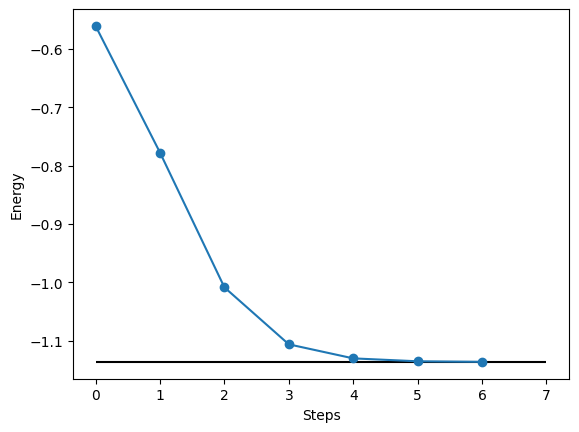

In [27]:
import matplotlib.pyplot as plt

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, iterations, colors="black")
plt.plot(energies, "o-")
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()

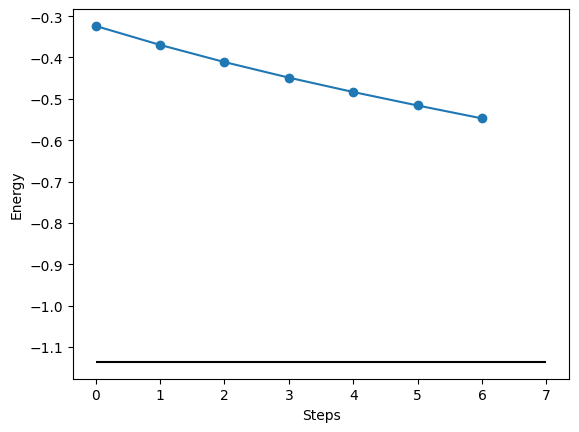

In [31]:
import matplotlib.pyplot as plt

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, iterations, colors="black")
plt.plot(energies, "o-")
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()